# COGS 108 - EDA Checkpoint

# Names

- Andrew Hernandez
- Austin Nguyen
- Christian Kim
- Kevin De Silva Jayasinghe

<a id='research_question'></a>
# Research Question

*Does an increase in tweets with the hashtag description '#bitcoin' correlate with an increase in bitcoin price? What time frame relationship holds the strongest correlation?*
- Does the number of tweets about bitcoin in one week correlate with the change in price of bitcoin the next week?
- Is there a relationship between the number of tweets on a given day, and the change in price of bitcoin the day after?

# Setup

In [40]:
import pandas as pd
import numpy as np
import requests 
from bs4 import BeautifulSoup
import re
import patsy
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

# Data Cleaning

Describe your data cleaning steps here.

In [41]:
# Get daily bitcoin price from 01/01/2019 - 12/31/2019
btc_2019 = pd.read_csv('btc_2019.csv')

# Get daily bitcoin price from 01/01/2020 - 12/31/2020
btc_2020 = pd.read_csv('btc_2020.csv')

# Concatenate both years' data together into one dataframe
btc_2019_2020 = pd.concat([btc_2020, btc_2019])

# Remove commas of the open, high, low, and close to cast into int
btc_2019_2020 = btc_2019_2020.replace(',', '', regex=True)

# Cast the open, high, low, and close into ints so we can perform calculations on these values
btc_2019_2020 = btc_2019_2020.astype({'Open': 'int32', 'High': 'int32', 'Low': 'int32', 'Close': 'int32'})

# Create a new column called PriceChange which will be the difference between the close and open price.
# We will use this to tell how much the price changed (will be used in measuring the correlation)
btc_2019_2020 = btc_2019_2020.assign(PriceChange = (btc_2019_2020['Close'] - btc_2019_2020['Open']))

# Create a new column which converts the Date into DateTime so it is easier to work with and graph
btc_2019_2020['DateTime'] = pd.to_datetime(btc_2019_2020['Date'])

# Create a new column which converts the Date into DateTime and subtract 6 days so we can group the daily prices into weekly prices
# We will use this to group the data into weeks for the second part of the research question
btc_2019_2020['DateTimeGroup'] = pd.to_datetime(btc_2019_2020['Date']) - pd.to_timedelta(6, unit='d')

# Create two dataframes where the first gets the opening price of the week and the second gets the closing price of the week.
# The keys will be the same so we can merge them to create a single table
btc_2019_2020_weekly_open = btc_2019_2020.groupby(pd.Grouper(key='DateTimeGroup', freq='W-TUE'))[['Open']].first().reset_index().sort_values('DateTimeGroup')
btc_2019_2020_weekly_close = btc_2019_2020.groupby(pd.Grouper(key='DateTimeGroup', freq='W-TUE'))[['Close']].last().reset_index().sort_values('DateTimeGroup')

# Merge the two previous btc_2019_2020_weekly_open and btc_2019_2020_weekly_close tables.
# This weekly form of the dataset has the key of the first day of the week (where we know the end date is the day before the next key)
btc_2019_2020_weekly = pd.merge(btc_2019_2020_weekly_open, btc_2019_2020_weekly_close, on=['DateTimeGroup'])
btc_2019_2020_weekly = btc_2019_2020_weekly.assign(PriceChange = (btc_2019_2020_weekly['Close'] - btc_2019_2020_weekly['Open']))

print(btc_2019_2020_weekly)
btc_2019_2020
# The datasets were split up by year so we had to concatenate
# The data was already mostly clean so we only had to typecast the strings into integers and remove commas
# We then added a column which contains PriceChange which is what we will use to determine
# if the increase in tweets with the hashtag description '#bitcoin' correlates with an increase in bitcoin price
# We also added a column for datetime to make it easy to work with and to create a dataframe where we group it by weekly prices



    DateTimeGroup   Open  Close  PriceChange
0      2019-01-01   3722   4040          318
1      2019-01-08   4041   3693         -348
2      2019-01-15   3693   3537         -156
3      2019-01-22   3537   3442          -95
4      2019-01-29   3442   3445            3
..            ...    ...    ...          ...
100    2020-12-01  19380  19087         -293
101    2020-12-08  19087  19201          114
102    2020-12-15  19199  23146         3947
103    2020-12-22  23138  26634         3496
104    2020-12-29  26606  28966         2360

[105 rows x 4 columns]


,Date,Open,High,Low,Close,PriceChange,DateTime,DateTimeGroup
0,12/31/2020,28898,29298,27989,28966,68,2020-12-31,2020-12-25
1,12/30/2020,26870,28980,26870,28896,2026,2020-12-30,2020-12-24
2,12/29/2020,26606,27164,25926,26870,264,2020-12-29,2020-12-23
3,12/28/2020,26303,27404,26136,26634,331,2020-12-28,2020-12-22
4,12/27/2020,26666,28326,25824,26303,-363,2020-12-27,2020-12-21
...,...,...,...,...,...,...,...,...
360,01/05/2019,3878,3912,3859,3880,2,2019-01-05,2018-12-30
361,01/04/2019,3840,3895,3774,3878,38,2019-01-04,2018-12-29
362,01/03/2019,3937,3964,3813,3841,-96,2019-01-03,2018-12-28
363,01/02/2019,3767,3943,3757,3931,164,2019-01-02,2018-12-27


In [42]:
# We found this web scraping script at https://stackoverflow.com/questions/47730259/installing-urllib-in-python3-6 
# and made some minor modifications in order to fit to our needs in terms of retrieving the amount of tweets on a daily basis.
# We have to further clean the data by extracting all days between 01/01/2019 - 12/31/2020 and then 
# grouping the data into a weekly format (sum amount of tweets for all days in a given week) 
# in order answer the second part of our question

# Function to clean the string
def parse_strlist(sl):
    # Remove the uncessary commans and brackets
    clean = re.sub("[\[\],\s]","",sl)
    # Split the remaining text by " to a list where a date is followed by the number of tweets
    splitted = re.split("[\'\"]",clean)
    # Filter out empty segments of the array since the " occurs at the beginning leading to an empty string in the list
    values_only = [s for s in splitted if s != '']
    return values_only

# Make a request to the website with the dataset and parse its html
url = 'https://bitinfocharts.com/comparison/tweets-btc.html#3y'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Since the data is stored in the script tags we will search in there
scripts = soup.find_all('script', text=True)
for script in scripts:
    # The script tag we are looking for contains this content inside so we will parse it if we find this string inside
    if 'd = new Dygraph(document.getElementById("container")' in str(script):
        # Since there are various things inside the script tag, we will search for the array holding the date specifically
        StrList = str(script)
        StrList = '[[' + StrList.split('[[')[-1]
        StrList = StrList.split(']]')[0] +']]'
        # We will replace the js date parser surrounding the date we want
        StrList = StrList.replace("new Date(", '').replace(')','')
        # Parse the string into an list so we can create the dataframe
        dataList = parse_strlist(StrList)

        # Make a dataframe from the parsed data
        date = []
        tweet = []
        for each in dataList:
            if (dataList.index(each) % 2) == 0:
                date.append(each)
            else:
                tweet.append(each)
        tweet_df = pd.DataFrame(list(zip(date, tweet)), columns=["Date","BTC - Tweets"])

# This dataframe has one null value so we will need to remove it
tweet_df = tweet_df[tweet_df["BTC - Tweets"] != "null"]

# Cast the tweet count into ints so we can perform calculations on these values
tweet_df = tweet_df.astype({'BTC - Tweets': 'int64'})

tweet_df

,Date,BTC - Tweets
0,2014/04/09,8193
1,2014/04/10,15039
2,2014/04/11,14907
3,2014/04/12,7582
4,2014/04/13,10674
...,...,...
2595,2021/05/17,184558
2596,2021/05/18,120021
2597,2021/05/19,363566
2598,2021/05/20,173415


In [43]:
# Filter our tweet dataframe so that we only include the tweet counts from the years 2019 and 2020
tweets_2019_2020 = tweet_df[(tweet_df.Date.str.contains("2019", na=False)) | (tweet_df.Date.str.contains("2020", na=False))]

# Create a new column which converts the Date into DateTime so it is easier to work with and graph
tweets_2019_2020['DateTime'] = pd.to_datetime(tweets_2019_2020['Date'])

# Create a new column which converts the Date into DateTime and subtract 6 days so we can group the daily tweet count into tweet count prices
# We will use this to group the data into weeks for the second part of the research question
tweets_2019_2020['DateTimeGroup'] = pd.to_datetime(tweets_2019_2020['Date']) - pd.to_timedelta(6, unit='d')

# Group the number of tweets by week
tweets_2019_2020_weekly = tweets_2019_2020.groupby(pd.Grouper(key='DateTimeGroup', freq='W-TUE'))[['BTC - Tweets']].sum().reset_index().sort_values('DateTimeGroup')

print(tweets_2019_2020)
tweets_2019_2020_weekly

            Date  BTC - Tweets   DateTime DateTimeGroup
1728  2019/01/01         17069 2019-01-01    2018-12-26
1729  2019/01/02         18830 2019-01-02    2018-12-27
1730  2019/01/03         26754 2019-01-03    2018-12-28
1731  2019/01/04         21139 2019-01-04    2018-12-29
1732  2019/01/05         20096 2019-01-05    2018-12-30
...          ...           ...        ...           ...
2454  2020/12/27         88788 2020-12-27    2020-12-21
2455  2020/12/28         59779 2020-12-28    2020-12-22
2456  2020/12/29         56236 2020-12-29    2020-12-23
2457  2020/12/30         80886 2020-12-30    2020-12-24
2458  2020/12/31         68822 2020-12-31    2020-12-25

[730 rows x 4 columns]
<ipython-input-43-f0bbf4b1f75f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

,DateTimeGroup,BTC - Tweets
0,2019-01-01,143247
1,2019-01-08,132086
2,2019-01-15,130601
3,2019-01-22,125986
4,2019-01-29,123895
...,...,...
100,2020-12-01,323904
101,2020-12-08,278768
102,2020-12-15,539526
103,2020-12-22,402965


In [44]:
# Manually create a dataframe with monthly twitter users from "Twitter Monthly Active"
twitter_monthly_users_data = { 'Quarter': ['Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4'],
         'Year': [2019,2019,2019,2019,2020,2020,2020,2020],
         'MUA':  [330000000,330000000,330000000,340000000,326000000,326000000,353000000,np.nan]}

twitter_monthly_users = pd.DataFrame(twitter_monthly_users_data)
twitter_monthly_users

,Quarter,Year,MUA
0,Q1,2019,330000000.0
1,Q2,2019,330000000.0
2,Q3,2019,330000000.0
3,Q4,2019,340000000.0
4,Q1,2020,326000000.0
5,Q2,2020,326000000.0
6,Q3,2020,353000000.0
7,Q4,2020,NaN


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [45]:
# append tweet data to btc dataframe
btc_2019_2020_weekly['tweets'] = tweets_2019_2020_weekly['BTC - Tweets']
btc_2019_2020_weekly['tweet_week'] = tweets_2019_2020_weekly['DateTimeGroup']  # sanity check making sure correct weeks ae being added

btc_2019_2020_weekly

,DateTimeGroup,Open,Close,PriceChange,tweets,tweet_week
0,2019-01-01,3722,4040,318,143247,2019-01-01
1,2019-01-08,4041,3693,-348,132086,2019-01-08
2,2019-01-15,3693,3537,-156,130601,2019-01-15
3,2019-01-22,3537,3442,-95,125986,2019-01-22
4,2019-01-29,3442,3445,3,123895,2019-01-29
...,...,...,...,...,...,...
100,2020-12-01,19380,19087,-293,323904,2020-12-01
101,2020-12-08,19087,19201,114,278768,2020-12-08
102,2020-12-15,19199,23146,3947,539526,2020-12-15
103,2020-12-22,23138,26634,3496,402965,2020-12-22


In [46]:
btc_tweets_2019_2020_daily = pd.merge(btc_2019_2020, tweets_2019_2020, how="left", on=['DateTime'])
btc_tweets_2019_2020_daily

,Date_x,Open,High,Low,Close,PriceChange,DateTime,DateTimeGroup_x,Date_y,BTC - Tweets,DateTimeGroup_y
0,12/31/2020,28898,29298,27989,28966,68,2020-12-31,2020-12-25,2020/12/31,68822.0,2020-12-25
1,12/30/2020,26870,28980,26870,28896,2026,2020-12-30,2020-12-24,2020/12/30,80886.0,2020-12-24
2,12/29/2020,26606,27164,25926,26870,264,2020-12-29,2020-12-23,2020/12/29,56236.0,2020-12-23
3,12/28/2020,26303,27404,26136,26634,331,2020-12-28,2020-12-22,2020/12/28,59779.0,2020-12-22
4,12/27/2020,26666,28326,25824,26303,-363,2020-12-27,2020-12-21,2020/12/27,88788.0,2020-12-21
...,...,...,...,...,...,...,...,...,...,...,...
726,01/05/2019,3878,3912,3859,3880,2,2019-01-05,2018-12-30,2019/01/05,20096.0,2018-12-30
727,01/04/2019,3840,3895,3774,3878,38,2019-01-04,2018-12-29,2019/01/04,21139.0,2018-12-29
728,01/03/2019,3937,3964,3813,3841,-96,2019-01-03,2018-12-28,2019/01/03,26754.0,2018-12-28
729,01/02/2019,3767,3943,3757,3931,164,2019-01-02,2018-12-27,2019/01/02,18830.0,2018-12-27


In [47]:
btc_tweets_2019_2020_daily['BTC - Tweets'] = btc_tweets_2019_2020_daily['BTC - Tweets'].shift(-1)
btc_tweets_2019_2020_daily

,Date_x,Open,High,Low,Close,PriceChange,DateTime,DateTimeGroup_x,Date_y,BTC - Tweets,DateTimeGroup_y
0,12/31/2020,28898,29298,27989,28966,68,2020-12-31,2020-12-25,2020/12/31,80886.0,2020-12-25
1,12/30/2020,26870,28980,26870,28896,2026,2020-12-30,2020-12-24,2020/12/30,56236.0,2020-12-24
2,12/29/2020,26606,27164,25926,26870,264,2020-12-29,2020-12-23,2020/12/29,59779.0,2020-12-23
3,12/28/2020,26303,27404,26136,26634,331,2020-12-28,2020-12-22,2020/12/28,88788.0,2020-12-22
4,12/27/2020,26666,28326,25824,26303,-363,2020-12-27,2020-12-21,2020/12/27,72172.0,2020-12-21
...,...,...,...,...,...,...,...,...,...,...,...
726,01/05/2019,3878,3912,3859,3880,2,2019-01-05,2018-12-30,2019/01/05,21139.0,2018-12-30
727,01/04/2019,3840,3895,3774,3878,38,2019-01-04,2018-12-29,2019/01/04,26754.0,2018-12-29
728,01/03/2019,3937,3964,3813,3841,-96,2019-01-03,2018-12-28,2019/01/03,18830.0,2018-12-28
729,01/02/2019,3767,3943,3757,3931,164,2019-01-02,2018-12-27,2019/01/02,17069.0,2018-12-27


In [48]:
btc_tweets_2019_2020_weekly_staggered = pd.merge(btc_2019_2020_weekly, tweets_2019_2020_weekly)
btc_tweets_2019_2020_weekly_staggered['BTC - Tweets'] = btc_tweets_2019_2020_weekly_staggered['BTC - Tweets'].shift(+1)
btc_tweets_2019_2020_weekly_staggered

,DateTimeGroup,Open,Close,PriceChange,tweets,tweet_week,BTC - Tweets
0,2019-01-01,3722,4040,318,143247,2019-01-01,NaN
1,2019-01-08,4041,3693,-348,132086,2019-01-08,143247.0
2,2019-01-15,3693,3537,-156,130601,2019-01-15,132086.0
3,2019-01-22,3537,3442,-95,125986,2019-01-22,130601.0
4,2019-01-29,3442,3445,3,123895,2019-01-29,125986.0
...,...,...,...,...,...,...,...
100,2020-12-01,19380,19087,-293,323904,2020-12-01,359769.0
101,2020-12-08,19087,19201,114,278768,2020-12-08,323904.0
102,2020-12-15,19199,23146,3947,539526,2020-12-15,278768.0
103,2020-12-22,23138,26634,3496,402965,2020-12-22,539526.0


This histogram visualizes the frequency of the price changes of bitcoin on any given week. For the most part, it averages between +-500 dollars a week. However there were occasions of larger changes going into the 3500 dollar range.

<AxesSubplot:>

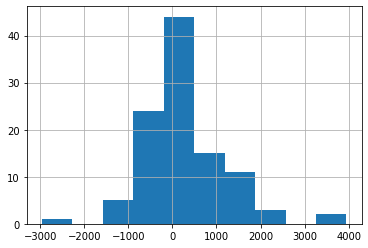

In [49]:
btc_2019_2020_weekly['PriceChange'].hist()

This histogram visualizes the distribution of tweets conataining "#Bitcoin" in a given week. The average seems to lie around 150k

<AxesSubplot:>

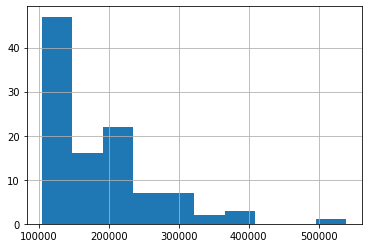

In [50]:
btc_2019_2020_weekly['tweets'].hist()

 Below we created a time series chart to showcase the change in number of tweets and the price of Bitcoin over the January 2019 to December 2020 time frame.

 We can see there seems to be a corelation between the two graphs. From 01/2019 - 01/2020 they both have small fluctuations then we see what seems to be an inversse relationship from  about 02/2020 - 10/2020. Finally around 12/2020 we see a strong reltionship between the two where it seems as if a large increase in tweets is followed by a large price increase then a large decrease in tweets leads to a large decrease in price. Ovcerall, the graph below visually suggests there may be a relationship betweeb price change and tweets. 

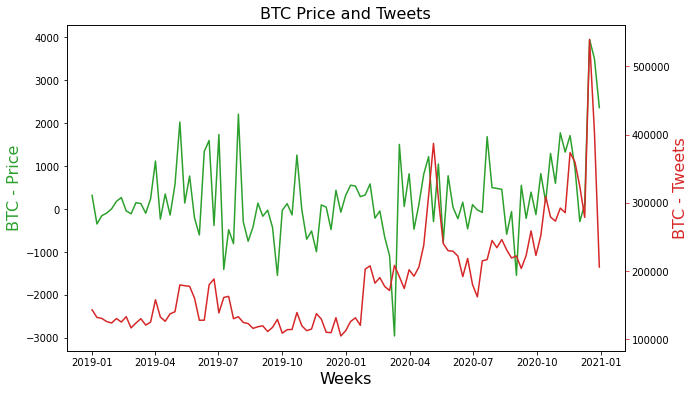

In [51]:
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
ax1.set_title('BTC Price and Tweets', fontsize=16)
ax1.set_xlabel('Weeks', fontsize=16)
ax1.set_ylabel('BTC - Price', fontsize=16, color=color)
ax2 = sns.lineplot(x ='DateTimeGroup', y ='PriceChange', data=btc_2019_2020_weekly, color=color)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('BTC - Tweets', fontsize=16, color=color)
ax2 = sns.lineplot(x ='DateTimeGroup', y ='tweets', data=btc_2019_2020_weekly, color=color)
ax2.tick_params(axis='y', color=color)
plt.show()

Execute a linear regression to find the effect of the weekly number of tweets on the weekly price change of bitcoin

In [52]:
outcome, predictors = patsy.dmatrices('PriceChange ~ tweets', btc_2019_2020_weekly)
mod = sm.OLS(outcome, predictors)
res = mod.fit() 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            PriceChange   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     26.64
Date:                Fri, 21 May 2021   Prob (F-statistic):           1.20e-06
Time:                        13:08:00   Log-Likelihood:                -857.02
No. Observations:                 105   AIC:                             1718.
Df Residuals:                     103   BIC:                             1723.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -807.2356    219.560     -3.677      0.0

Based on the linear regression, we see that there is a correlation between tweets the the price change of bitcoin (as there is a p-value of 0.000). The linear regression suggest if there are no tweets on bitcoin, the value of the coin would drop 806.2356 USD a week. Each tweet in the corresponding week would increase the value of the coin by 0.0056 USD.

Here we visualize the linear regression. As we saw in the data, there is a positive correlation between tweets and an increase in bitcoin price change

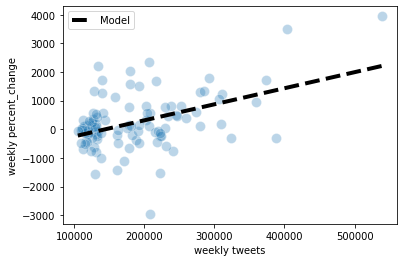

In [53]:
sns.scatterplot(x='tweets', y='PriceChange', data=btc_2019_2020_weekly, alpha=0.3, s=100)

# Generate and plot the model fit line
xs = np.arange(btc_2019_2020_weekly['tweets'].min(), btc_2019_2020_weekly['tweets'].max())
ys = 0.0056* xs - 807.2356
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

plt.xlabel('weekly tweets')
plt.ylabel('weekly percent_change')
plt.legend()